0. Preparation
Before any analyses we will prepare the dataset for the subsequent modelling.

1. Load the Auto dataset into R or Python.

In [280]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

Auto=pd.read_csv("Auto.csv")

2. Drop all variables except the (potential) predictors ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'] and the target variable 'mpg'.

In [281]:
# keep the predictors and the outcome varibales 
predictors = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
target = 'mpg'
auto = Auto[predictors + [target]]

3. Split the dataset into a training set (80%) and a validation set (20%). It is probably a good idea to set a random seed and shuffle the dataset prior to this.

In [282]:
#split the dataset to training and validation sets(80%,20%)
train_data, val_data = train_test_split(auto, test_size=0.2, shuffle=True, random_state=100)

4. Replace missing values (coded as '?') in the both datasets with the mean of the given variable in the training set.

In [283]:

# check ? values
# print((train_data == '?').sum())
# print((val_data == '?').sum())
# print(train_data.isna().sum())
# print(val_data.isna().sum())

    
for col in predictors + [target]:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')

for col in predictors:
    mean_val = train_data[col].mean()
    train_data[col] = train_data[col].fillna(mean_val)
    val_data[col] = val_data[col].fillna(mean_val)



5. Standardize the predictors in the training set using z-score standardization.
6. Standardize the predictors in validation set based on the means and standard deviations from the training set.

In [284]:
# Standardize predictors for both training and validation sets based on training set
scaler = StandardScaler()
train_data[predictors] = scaler.fit_transform(train_data[predictors])
val_data[predictors] = scaler.transform(val_data[predictors])

7. Reflection: Discuss briefly why it is a good idea (or even necessary?) to standardize the variables before fitting the LASSO models in assignment 2. Why do we mean-fill and standardize the validation set based on information from the training set?

It is a good idea and necessary to standardize the variables because this gives us the same scale/unit of the coefficients. Shrinkage penalizes  the coefficients directly regardless of the scales. If we do not standardize it, variables on larger scales will be penalized less than those on smaller scales. We use the information from the training set because we want to keep the model agnostic to the validation set during training

1. Manual variable selection
In this assignment all models should be unregularized linear regression models fitted to predict mpg as a function of various subset of predictors. When we refer to the best model we mean the one achieving the lowest mean absolute error (MAE) in the validation set, if not otherwise specified.

1. Find the optimal set of predictors of size [6, 5, 4, 3, 2, 1] based on model performance using backward stepwise selection. Print out each set.


In [285]:

current_predictors = predictors.copy()
all_models = {}  

# Loop until we reach 1 predictor
while len(current_predictors) > 1:
    best_model = {'mae': float('inf'), 'predictors': None}

    for predictor in current_predictors:
        reduced_predictors = [p for p in current_predictors if p != predictor]

        model = LinearRegression()
        model.fit(train_data[reduced_predictors], train_data[target])
        predictions = model.predict(val_data[reduced_predictors])
        mae = mean_absolute_error(val_data[target], predictions)

        if mae < best_model['mae']:
            best_model = {'mae': mae, 'predictors': reduced_predictors}

    current_predictors = best_model['predictors']
    all_models[len(current_predictors)] = current_predictors.copy()  

all_models[len(predictors)] = predictors.copy()

# Print results for each model size
print("Optimal sets of predictors using Backward Stepwise Selection based on MAE:")
for size in sorted(all_models.keys(), reverse=True):
    print(f"{size} predictors: {all_models[size]}")


Optimal sets of predictors using Backward Stepwise Selection based on MAE:
6 predictors: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
5 predictors: ['cylinders', 'horsepower', 'weight', 'acceleration', 'year']
4 predictors: ['horsepower', 'weight', 'acceleration', 'year']
3 predictors: ['weight', 'acceleration', 'year']
2 predictors: ['weight', 'year']
1 predictors: ['weight']


2. Based on the models you have already trained, plot both training and validation MAE as a function of the number of predictors.

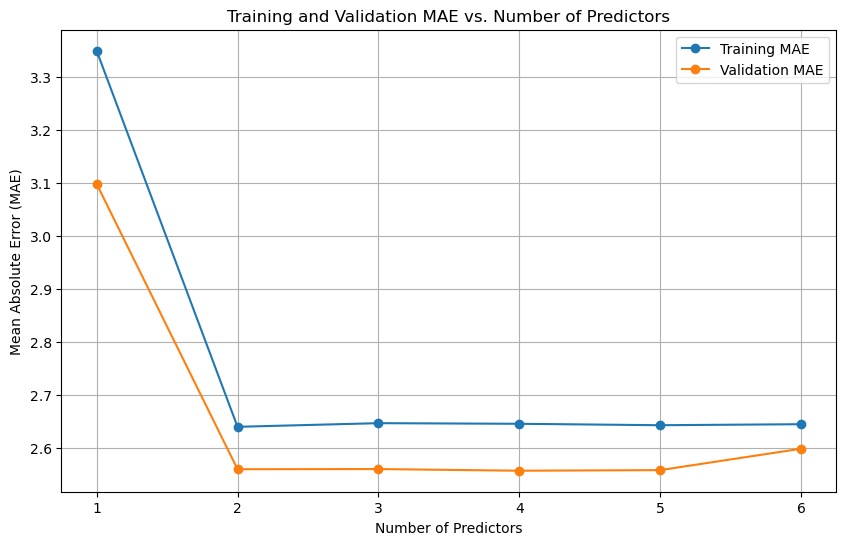

Optimal sets of predictors using Backward Stepwise Selection based on MAE:
5 predictors: ['cylinders', 'horsepower', 'weight', 'acceleration', 'year']
4 predictors: ['horsepower', 'weight', 'acceleration', 'year']
3 predictors: ['weight', 'acceleration', 'year']
2 predictors: ['weight', 'year']
1 predictors: ['weight']
Number of Predictors: [5, 4, 3, 2, 1, 6]
Training MAEs: [2.642113358087504, 2.6448006264701385, 2.6459770972373087, 2.6391076286724817, 3.349108611274721, 2.644006581728108]
Validation MAEs: [2.5573447829738614, 2.5562005126644523, 2.5593489669994165, 2.5590213271092415, 3.097679537033167, 2.5977346307305877]


In [286]:
# Initialize lists to store the MAE values
train_maes = []
val_maes = []
num_predictors = []

current_predictors = predictors.copy()
all_models = {}

# Loop until we reach 1 predictor
while len(current_predictors) > 1:
    best_model = {'mae': float('inf'), 'train_mae': float('inf'), 'val_mae': float('inf'), 'predictors': None}

    for predictor in current_predictors:
        reduced_predictors = [p for p in current_predictors if p != predictor]

        model = LinearRegression()
        model.fit(train_data[reduced_predictors], train_data[target])
        
        # Training and validation predictions
        train_predictions = model.predict(train_data[reduced_predictors])
        val_predictions = model.predict(val_data[reduced_predictors])
        
        # Calculate MAE for both training and validation
        train_mae = mean_absolute_error(train_data[target], train_predictions)
        val_mae = mean_absolute_error(val_data[target], val_predictions)

        # If this model is better, update the best_model
        if val_mae < best_model['val_mae']:
            best_model = {'mae': train_mae, 'train_mae': train_mae, 'val_mae': val_mae, 'predictors': reduced_predictors}

    # Store the training and validation MAEs for the current model
    current_predictors = best_model['predictors']
    train_maes.append(best_model['train_mae'])
    val_maes.append(best_model['val_mae'])
    num_predictors.append(len(current_predictors))

    all_models[len(current_predictors)] = current_predictors.copy()

# Final model with all predictors
train_maes.append(mean_absolute_error(train_data[target], LinearRegression().fit(train_data[predictors], train_data[target]).predict(train_data[predictors])))
val_maes.append(mean_absolute_error(val_data[target], LinearRegression().fit(train_data[predictors], train_data[target]).predict(val_data[predictors])))
num_predictors.append(len(predictors))

sorted_indices = sorted(range(len(num_predictors)), key=lambda k: num_predictors[k])
num_predictors_sorted = [num_predictors[i] for i in sorted_indices]
train_maes_sorted = [train_maes[i] for i in sorted_indices]
val_maes_sorted = [val_maes[i] for i in sorted_indices]

# Plotting the training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(num_predictors_sorted, train_maes_sorted, label="Training MAE", marker='o', linestyle='-')
plt.plot(num_predictors_sorted, val_maes_sorted, label="Validation MAE", marker='o', linestyle='-')
plt.xlabel("Number of Predictors")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Training and Validation MAE vs. Number of Predictors")
plt.legend()
plt.grid(True)
plt.show()

# Print results for each model size
print("Optimal sets of predictors using Backward Stepwise Selection based on MAE:")
for size in sorted(all_models.keys(), reverse=True):
    print(f"{size} predictors: {all_models[size]}")
    
print("Number of Predictors:", num_predictors)
print("Training MAEs:", train_maes)
print("Validation MAEs:", val_maes)



3. Plot mpg predictions against actual mpg values for the validation set using the best model.

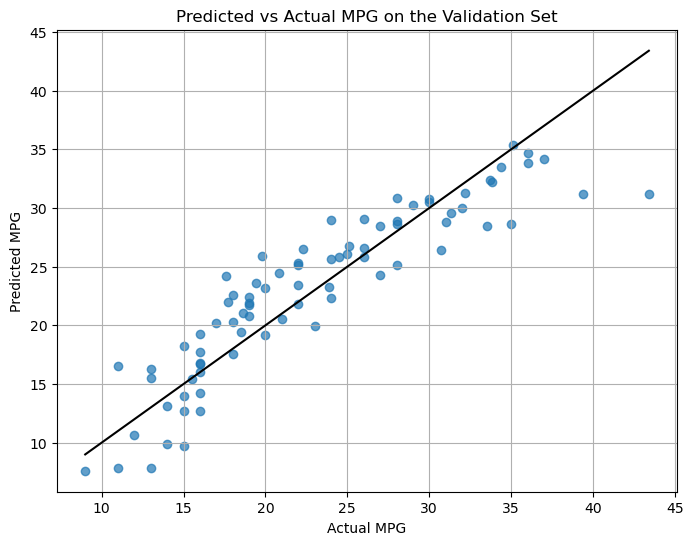

In [306]:

best_predictors = ['horsepower', 'weight', 'acceleration', 'year']

# Train the final model using the best predictors
best_model = LinearRegression()
best_model.fit(train_data[best_predictors], train_data[target])

# Make predictions on the validation set
val_predictions = best_model.predict(val_data[best_predictors])

# Plotting the predicted vs actual mpg values
plt.figure(figsize=(8, 6))
plt.scatter(val_data[target], val_predictions, alpha=0.7)
plt.plot([val_data[target].min(), val_data[target].max()], 
         [val_data[target].min(), val_data[target].max()], 
         color='black')
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Predicted vs Actual MPG on the Validation Set")
plt.grid(True)
plt.show()


4. Reflection: What is the best model based on training MAE? What about validation MAE? If they are different, reflect briefly on why. If not, could this happen? Why/why not?
The best model based on training MAE is the model with 2 predictors: ['weight', 'year'], while the best model based on validation MAE is with 4 predictors: ['horsepower', 'weight', 'acceleration', 'year']. The best model based on training MAE is different from the best model based on validation MAE. This may happen due to overfitting where a model performs well on training data but not generalizing well to validation data. 

2. Regularization and automatic variable selection

1. Fit a range of LASSO models to predict mpg using all the predictors, with eleven lambdas uniformly spaced between 0 and 10 (e.g. 0, 1, 2, ..., 9, 10)

In [295]:
# LASSO Regularization
lambdas = np.linspace(0, 10, 11)
train_mae_lasso = []
val_mae_lasso = []

for l in lambdas:
    lasso = Lasso(alpha=l)
    lasso.fit(train_data[predictors], train_data[target])
    
    train_mae_lasso.append(mean_absolute_error(train_data[target], lasso.predict(train_data[predictors])))
    val_mae_lasso.append(mean_absolute_error(val_data[target], lasso.predict(val_data[predictors])))


/Users/qiqi/miniforge3/envs/python-for-scicomp/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/qiqi/miniforge3/envs/python-for-scicomp/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/qiqi/miniforge3/envs/python-for-scicomp/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e+03, tolerance: 1.952e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the 

2. Plot the train and validation MAE as a function of the value of lambda


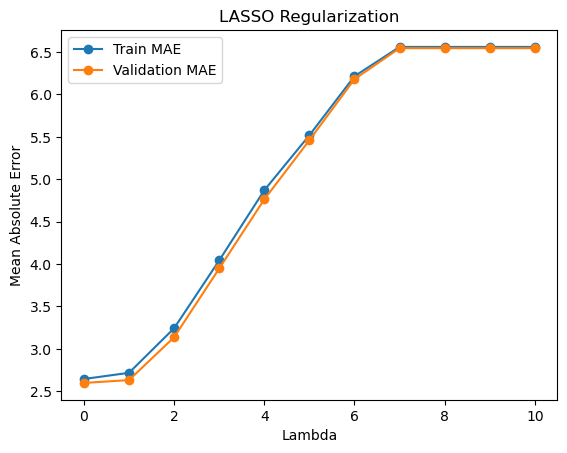

In [296]:
plt.plot(lambdas, train_mae_lasso, label="Train MAE", marker='o')
plt.plot(lambdas, val_mae_lasso, label="Validation MAE", marker='o')
plt.xlabel("Lambda")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.title("LASSO Regularization")
plt.show()

3. Using the values plotted in b), print the lambda yielding the best model based on training MAE and validation MAE, and their corresponding MAE values.

In [298]:
best_lambda_idx = np.argmin(val_mae_lasso)
best_lambda = lambdas[best_lambda_idx]
print(f"Best lambda: {best_lambda} with Validation MAE = {val_mae_lasso[best_lambda_idx]:.4f}")


Best lambda: 0.0 with Validation MAE = 2.5977


4. Reflection: Is the best model based on training MAE and validation MAE using the same lambda? If not, why not? What would be the general pattern we expect to see here?


The best model based on training MAE and validation MAE usually does not use the same lambda. Training MAE decreases as lambda approaches 0, which might lead to overfitting. Validation MAE usually follows a U-shape: it decreases at first, then increases as lambda gets larger, since higher lambda prevents overfitting but can lead to underfitting. However, I am not sure why in the plot above the validation set did not show a u shape.



5. Plot predictions against actual values and for the validation set using the best model.


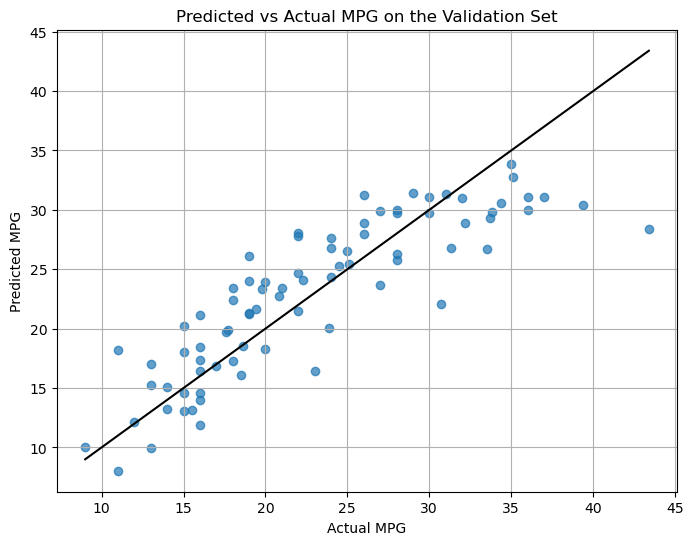

['weight']


In [ ]:
best_predictors = all_models[min(all_models.keys())]
best_model = LinearRegression()
best_model.fit(train_data[best_predictors], train_data[target])
val_predictions = best_model.predict(val_data[best_predictors])

plt.figure(figsize=(8, 6))
plt.scatter(val_data[target], val_predictions, alpha=0.7)
plt.plot([val_data[target].min(), val_data[target].max()], 
         [val_data[target].min(), val_data[target].max()], 
         color='black')
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Predicted vs Actual MPG on the Validation Set")
plt.grid(True)
plt.show()



6. Reflection: Is the best LASSO model better or worse than the best model found using backward stepwise selection? Discuss briefly why this is/is not the case.


The LASSO model(MAE=2.5977) is worse than the best model found using backward stepwise selection(MAE=2.5562), because the MAE is slightly larger. The MAE is larger for the LASSO model because LASSO regularization shrinks some coefficients to zero, which can lead to underfitting if important predictors are excluded. The regularization introduces bias to reduce variance, but if the lambda is not optimal, it may penalize the model too much, causing it to perform worse on the validation set. In contrast, the backward stepwise selection method retains the most relevant predictors based on their contribution to the model's performance, leading to a lower MAE.

7. Print the names and coefficients of the predictors that are used by the LASSO model (e.g. not set to 0). How does this compare to the list you found using backwards stepwise selection?

In [308]:
# Print the names and coefficients of the predictors used by the best LASSO model (non-zero coefficients)
lasso_coefficients = pd.DataFrame({'Feature': predictors, 'Coefficient': lasso_best.coef_})
lasso_coefficients = lasso_coefficients[lasso_coefficients['Coefficient'] != 0]
print("Nonzero LASSO coefficients:")
print(lasso_coefficients)

# Print results for stepwise selection
print("Optimal sets of predictors using Backward Stepwise Selection based on MAE:")
for size in sorted(all_models.keys(), reverse=True):
    print(f"{size} predictors: {all_models[size]}")

#coefficients
best_predictors = ['horsepower', 'weight', 'acceleration', 'year']

# Train the final model using the best predictors
best_model = LinearRegression()
best_model.fit(train_data[best_predictors], train_data[target])

# Make predictions on the validation set
val_predictions = best_model.predict(val_data[best_predictors])

# Get the coefficients of the predictors
coefficients = best_model.coef_

# Display the coefficients along with their respective predictors
coefficients_df = pd.DataFrame({
    'Predictor': best_predictors,
    'Coefficient': coefficients
})

print(coefficients_df)


Nonzero LASSO coefficients:
        Feature  Coefficient
0     cylinders    -0.988620
1  displacement     1.038329
2    horsepower    -0.404828
3        weight    -5.335664
4  acceleration    -0.030374
5          year     2.784826
Optimal sets of predictors using Backward Stepwise Selection based on MAE:
5 predictors: ['cylinders', 'horsepower', 'weight', 'acceleration', 'year']
4 predictors: ['horsepower', 'weight', 'acceleration', 'year']
3 predictors: ['weight', 'acceleration', 'year']
2 predictors: ['weight', 'year']
1 predictors: ['weight']
      Predictor  Coefficient
0    horsepower     0.103557
1        weight    -5.605659
2  acceleration     0.161341
3          year     2.907350


LASSO includes more predictors due to its regularization mechanism, which shrinks coefficients instead of excluding them entirely. In contrast, backward stepwise selection discards predictors based on their contribution to the model. I am not sure about the answers of the assignment this time:o Would there be a document on the solutions to these tasks? 